## Import code

In [1]:
from bayeslr.bayeslr import *

from scipy.stats import linregress, norm, pearsonr
import matplotlib.pyplot as plt 
import pandas as pd

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':2,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

## Model definition

Want to predict a single output $y \in \mathbb{R}$ given a vector of features $\mathbf{x} \in \mathbb{R}^d$ 

By defining a basis function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^m$, the model predicts $y$ as a linear combination of potentially non-linear functions of $\mathbf{x}$, weighted by regression coefficients $\mathbf{w} \in \mathbb{R}^m$.  

$$
y = \mathbf{w}^T \phi (\mathbf{x}) + \varepsilon
$$

The model assumes that measurements are corrupted by zero-mean Gaussian noise with precision $\beta$, 


$$
\varepsilon \sim \mathcal{N}(\varepsilon | 0, \beta^{-1})
$$

# Import data

In [2]:
df = pd.read_csv("data/Regressionmodel_formatted_EXP004.csv")
df

,Condition,Replicates,Day,CD,BT,BU,PV,CA,CH,CS,DP,EL,PC,CD abs end
0,CD-BT_1,1,35,1,1,0,0,0,0,0,0,0,0,0.000355
1,CD-BT_2,2,35,1,1,0,0,0,0,0,0,0,0,0.000721
2,CD-BT_3,3,35,1,1,0,0,0,0,0,0,0,0,0.000173
3,CD-BU_1,1,35,1,0,1,0,0,0,0,0,0,0,0.422873
4,CD-BU_2,2,35,1,0,1,0,0,0,0,0,0,0,0.342751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,CD-PC-CH_2,2,35,1,0,0,0,0,1,0,0,0,1,0.000000
89,CD-PC-CH_3,3,35,1,0,0,0,0,1,0,0,0,1,0.000000
90,CD-PC-CS_1,1,14,1,0,0,0,0,0,1,0,0,1,0.000000
91,CD-PC-EL_2,2,35,1,0,0,0,0,0,0,0,1,1,0.092879


In [3]:
# separate replicate num from condition
condition = [c.split("_")[0] for c in df.Condition.values]
df['Condition'] = condition
df

,Condition,Replicates,Day,CD,BT,BU,PV,CA,CH,CS,DP,EL,PC,CD abs end
0,CD-BT,1,35,1,1,0,0,0,0,0,0,0,0,0.000355
1,CD-BT,2,35,1,1,0,0,0,0,0,0,0,0,0.000721
2,CD-BT,3,35,1,1,0,0,0,0,0,0,0,0,0.000173
3,CD-BU,1,35,1,0,1,0,0,0,0,0,0,0,0.422873
4,CD-BU,2,35,1,0,1,0,0,0,0,0,0,0,0.342751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,CD-PC-CH,2,35,1,0,0,0,0,1,0,0,0,1,0.000000
89,CD-PC-CH,3,35,1,0,0,0,0,1,0,0,0,1,0.000000
90,CD-PC-CS,1,14,1,0,0,0,0,0,1,0,0,1,0.000000
91,CD-PC-EL,2,35,1,0,0,0,0,0,0,0,1,1,0.092879


In [4]:
# exclude CD since it's always there (not informative)
features = df.columns.values[4:-1]
features

# target is CD at end
target = 'CD abs end'

In [5]:
# split dataframes 
dfs = [df_i for condition, df_i in df.groupby("Condition") if "mono" not in condition]
df_mono = df.iloc[np.array(condition)=='CD mono'].copy()

In [6]:
# define basis function that accounts for all pairwise interactions
@jit
def basis(x):
    # return upper triangular elements of outerproduct 
    cross_terms = jnp.outer(x, x)[jnp.triu_indices(len(x), k=1)]
    return jnp.concatenate((jnp.array([1.]), x, cross_terms))
batch_basis = jit(vmap(basis))

# leave one out cross validation
y_true = []
y_pred = []
for k in range(len(dfs)):
    
    # get train and test dataframes
    dfs_train = [dfs[i] for i in range(len(dfs)) if i!=k]
    df_train = pd.concat((pd.concat(dfs_train), df_mono))
    df_test = dfs[k]
    
    # train matrix
    X = df_train[features].values
    y = df_train[target].values
    
    # scale y 
    ymean = np.mean(y)
    ystdv = np.std(y)
    y_scale = (y - ymean)/ystdv
    
    # test matrix
    X_test = df_test[features].values
    y_test = np.mean(df_test[target].values)
    
    # fit model 
    blr = LR()
    blr.fit(batch_basis(X), y_scale)
    
    # predict (C. diff > 0)
    y_pred_k = np.clip(blr.predict(batch_basis(X_test[:1]))[0][0]*ystdv + ymean, 0., np.inf)
    
    # save values
    y_true.append(y_test)
    y_pred.append(y_pred_k)
    
# convert to array 
y_true = np.array(y_true)
y_pred = np.array(y_pred)

Evidence -41.155
Evidence -18.226
Evidence -7.090
Evidence -1.783
Evidence 0.893
Evidence 2.367
Evidence 3.262
Evidence 3.851
Evidence 4.263
Evidence 4.565
Evidence 4.794
Evidence 4.974
Evidence 5.117
Evidence 5.233
Evidence 5.330
Evidence 5.410
Evidence 5.478
Evidence 5.536
Evidence 5.586
Evidence 5.629
Evidence 5.667
Evidence 5.700
Evidence 5.729
Evidence 5.755
Evidence 5.778
Evidence 5.799
Evidence 5.817
Evidence 5.834
Evidence 5.848
Evidence 5.862
Evidence 5.874
Evidence 5.885
Evidence 5.895
Evidence 5.904
Evidence 5.912
Evidence 5.920
Evidence 5.927
Evidence 5.934
Evidence 5.939
Pass count  1
Evidence -40.272
Evidence -16.383
Evidence -4.590
Evidence 0.957
Evidence 3.615
Evidence 5.015
Evidence 5.845
Evidence 6.385
Evidence 6.762
Evidence 7.038
Evidence 7.247
Evidence 7.411
Evidence 7.542
Evidence 7.648
Evidence 7.736
Evidence 7.810
Evidence 7.872
Evidence 7.925
Evidence 7.970
Evidence 8.010
Evidence 8.045
Evidence 8.075
Evidence 8.101
Evidence 8.125
Evidence 8.146
Evidence 8.165


Evidence -40.770
Evidence -15.888
Evidence -3.787
Evidence 1.723
Evidence 4.326
Evidence 5.709
Evidence 6.539
Evidence 7.084
Evidence 7.466
Evidence 7.748
Evidence 7.963
Evidence 8.131
Evidence 8.267
Evidence 8.377
Evidence 8.468
Evidence 8.545
Evidence 8.610
Evidence 8.665
Evidence 8.713
Evidence 8.755
Evidence 8.791
Evidence 8.823
Evidence 8.852
Evidence 8.877
Evidence 8.899
Evidence 8.919
Evidence 8.938
Evidence 8.954
Evidence 8.969
Evidence 8.982
Evidence 8.994
Evidence 9.005
Evidence 9.015
Evidence 9.025
Evidence 9.033
Pass count  1
Evidence -40.927
Evidence -16.986
Evidence -4.975
Evidence 0.781
Evidence 3.591
Evidence 5.105
Evidence 6.014
Evidence 6.610
Evidence 7.027
Evidence 7.331
Evidence 7.562
Evidence 7.743
Evidence 7.887
Evidence 8.004
Evidence 8.101
Evidence 8.182
Evidence 8.251
Evidence 8.309
Evidence 8.360
Evidence 8.405
Evidence 8.444
Evidence 8.478
Evidence 8.508
Evidence 8.535
Evidence 8.560
Evidence 8.582
Evidence 8.601
Evidence 8.619
Evidence 8.635
Evidence 8.650
E

Evidence -40.704
Evidence -16.152
Evidence -4.151
Evidence 1.284
Evidence 3.861
Evidence 5.239
Evidence 6.068
Evidence 6.614
Evidence 6.996
Evidence 7.277
Evidence 7.492
Evidence 7.660
Evidence 7.795
Evidence 7.904
Evidence 7.995
Evidence 8.071
Evidence 8.136
Evidence 8.191
Evidence 8.239
Evidence 8.280
Evidence 8.316
Evidence 8.348
Evidence 8.376
Evidence 8.401
Evidence 8.424
Evidence 8.444
Evidence 8.462
Evidence 8.478
Evidence 8.493
Evidence 8.506
Evidence 8.518
Evidence 8.529
Evidence 8.540
Evidence 8.549
Evidence 8.557
Evidence 8.565
Pass count  1
Evidence -41.214
Evidence -17.001
Evidence -5.237
Evidence 0.188
Evidence 2.766
Evidence 4.131
Evidence 4.944
Evidence 5.476
Evidence 5.848
Evidence 6.121
Evidence 6.328
Evidence 6.491
Evidence 6.621
Evidence 6.727
Evidence 6.815
Evidence 6.889
Evidence 6.951
Evidence 7.004
Evidence 7.050
Evidence 7.089
Evidence 7.124
Evidence 7.154
Evidence 7.181
Evidence 7.205
Evidence 7.226
Evidence 7.245
Evidence 7.262
Evidence 7.277
Evidence 7.291
E

In [7]:
linregress(y_true, y_pred)

LinregressResult(slope=0.6319551159768233, intercept=0.09617320050586864, rvalue=0.7737875730521528, pvalue=4.584528113680428e-10, stderr=0.07889314861912095, intercept_stderr=0.021390713316653875)

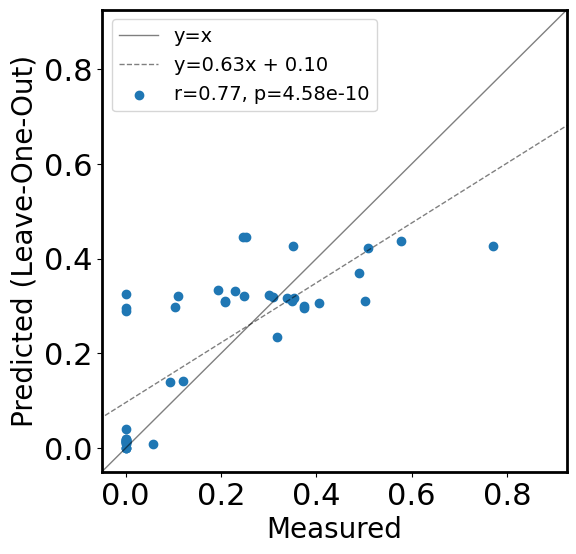

In [8]:
plt.figure(figsize=(6,6))

m, b, rval, pval, _ = linregress(y_true, y_pred)

plt.plot([-1., 1.5*max(y_true)], [-1., 1.5*max(y_true)], linewidth=1, label='y=x', c='k', alpha=.5)
x = np.linspace(-1., 1.5*max(y_true))
y = m*x + b
plt.plot(x, y, linewidth=1, linestyle='--', c='k', alpha=.5,
         label=f"y={m:.2f}x + {b:.2f}")
plt.scatter(y_true, y_pred, label=f"r={rval:.2f}, p={pval:.2e}")
plt.legend(fontsize=14)

plt.xlim([-.05, 1.2*max(y_true)])
plt.ylim([-.05, 1.2*max(y_true)])

plt.xlabel("Measured")
plt.ylabel("Predicted (Leave-One-Out)")
# plt.savefig("figures/LR/LR_LOO.pdf")
plt.show()